# Inverse Kinematics using Gradient Descent

Author: Michael Greer

This notebook introduces iterative inverse kinematics via jacobian inversion.

In [1]:
import numpy as np
from numpy import cos, sin, pi

import matplotlib.pyplot as plt

import sympy as sp

### Forward Kinematics

First, we define a function to plot the planar robot

In [2]:
def plot_robot(links, joints):
    
    # Convert to list if it's an ndarray
    if (isinstance(joints, np.ndarray)):
        joints = joints.flatten().tolist()
    
    xs = [0]
    ys = [0]
    
    total_len = sum(links)
    
    total_q = 0
    
    for l,q in zip(links, joints):
        
        total_q += q
        
        xs.append(xs[-1] + l * cos(total_q))
        ys.append(ys[-1] + l * sin(total_q))
        
    plt.figure(figsize=(8,8))
    plt.plot(xs, ys)
    plt.ylim(-1 * total_len, total_len)
    plt.xlim(-1 * total_len, total_len)
    plt.title('Robot Manipulator Pose')
    
    return

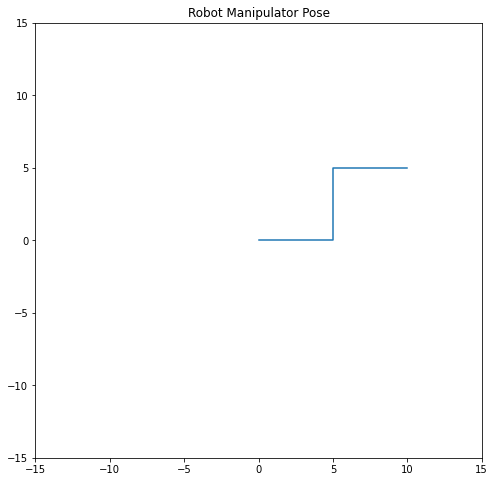

In [3]:
# Change the joint values to see how the arm moves

plot_robot([5, 5, 5], [0, pi/2, -pi/2])

From this, we can see that the forward kinematics are simply:

$$ x = \sum_{i=1}^n l_{i}cos(\sum_{j=1}^{i}q_{j})$$
$$ y = \sum_{i=1}^n l_{i}sin(\sum_{j=1}^{i}q_{j})$$

The forward kinematics give us the cartesian end effector position at a certain configuration, implemented in the function below.

In [4]:
def f_kine(links, joints):
    
    # Convert to list if it's an ndarray
    if (isinstance(joints, np.ndarray)):
        joints = joints.flatten().tolist()
    
    x = 0
    y = 0
    
    total_len = sum(links)
    
    total_q = 0
    
    for l,q in zip(links, joints):
        
        total_q += q
        
        x += l * cos(total_q)
        y += l * sin(total_q)
        
    return np.array([[x],[y]])

### Jacobian

The jacobian is simply an array comprised of the derivative of the forward kinematic function with respect to each of the joints, evaluated at those joint values. For the 2-D case, this is:

$$\begin{bmatrix} \frac{\partial f_{x}}{\partial q_{1}} & \frac{\partial f_{x}}{\partial q_{2}} & ... & \frac{\partial f_{x}}{\partial q_{n}} \\ \frac{\partial f_{y}}{\partial q_{1}} & \frac{\partial f_{y}}{\partial q_{2}} & ... & \frac{\partial f_{y}}{\partial q_{n}} \end{bmatrix}$$

Where n is the total number of joints in the robot. For simplicity in the code, the link and joint values are indexed at 0 instead of 1.

In [5]:
def jacobian(links, joints):
    
    # Convert to list if it's an ndarray
    if (isinstance(joints, np.ndarray)):
        joints = joints.flatten().tolist()
            
    # Form symbolic q matrix
    
    qs = []
    
    for i in range(0,len(joints)):
        
        qs.append(sp.Symbol('q{}'.format(i)))
        
        
    jac = np.zeros((2, len(links)))
    
    x = 0
    y = 0
    
    # Form forward kinematics
    for i in range(len(links)):
                   
        total_q = 0
        
        for j in range(i + 1):
            
            total_q += qs[j]
            
        x += links[i] * sp.cos(total_q)
        y += links[i] * sp.sin(total_q)
        
    
    # Differentiate to find jacobian      
    for i in range(len(links)):
        
        Jx = sp.diff(x, qs[i])
        Jy = sp.diff(y, qs[i])
        
        for k in range(len(links)):
            
            Jx = Jx.subs(qs[k], joints[k])
            Jy = Jy.subs(qs[k], joints[k])
                
        jac[0,i] = Jx.evalf()
        jac[1,i] = Jy.evalf()
            
    return jac

The significance of the jacobian is that it shows us each joint's ability to move the end effector in the x and y directions. The larger the value in the jacobian matrix, the greater that joint's ability to move the end effector in that direction. This also brings us to another method for calculating the jacobian which involves taking the cross product between the joint axis and the vector between the joint origin and the end effector, but that's a subject for another time. The relationship between joint movement and end effector movement can be shown as:
$$\dot{x}=J\dot{\theta}$$
We can rearrange this to form:
$$\dot{\theta}=J^{+}\dot{x}$$
Since the jacobian is not square in the redundant case, we use the psuedoinverse instead (denotated by the superscript +). Now we can specify a desired movement in the cartesian space, and use this to find what the corresponding movement should be in the joint space. Since this is a linear approximation, we limit the size of any individual $\dot{x}$ and repeat this process until we get close to our target.

In [6]:
# Note: this ONLY works for targets within the workspace. For points outside the workspace this function will not exit
def i_kine_G1(links, joints, target, error_trace=False):
    
    current_q = joints
    
    max_move = 5
    
    e_trace = []
    
    while(1):
        
        # Get the current end effector position
        current_x = f_kine(links, current_q)
        
        # Get the vector to the target
        delta_x = target - current_x
        
        # Find the magnitude of the movement required
        delta_x_norm = np.linalg.norm(delta_x)
        
        e_trace.append(delta_x_norm)
        
        #print(delta_x_norm)
        
        # Limit the maximum magnitude of delta_x
        if (delta_x_norm > max_move):
            
            delta_x /= (delta_x_norm / max_move)
            
        # Stop if the end effector is sufficently close to target
        if (delta_x_norm < 0.01):
            
            break
            
        jac = jacobian(links, current_q)
        
        # Find the required movements in the joint space
        alpha = 0.001
        delta_q = alpha * jac.T @ delta_x
        
        # Add the change to find the updated joint angles
        current_q += delta_q
        
    return (current_q, e_trace) if error_trace else current_q

Text(0.5, 1.0, 'Error Trace')

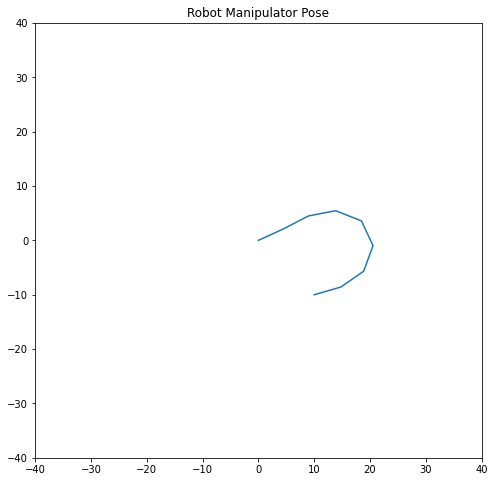

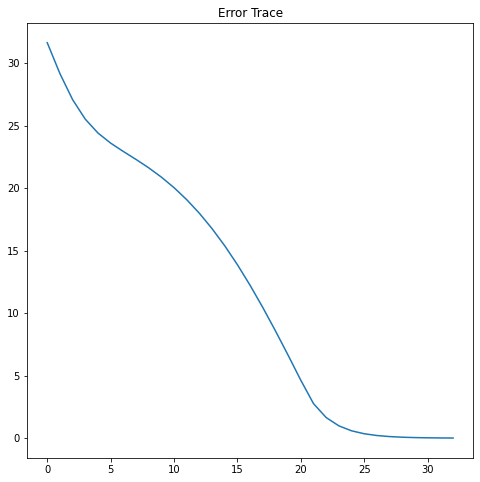

In [8]:
links = [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
joints = np.array([[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0]])
target = np.array([[10.0],[-10.0]])

joints, e_trace = i_kine_G1(links, joints, target, error_trace=True)

plot_robot(links, joints)

plt.figure(figsize=(8,8))
plt.plot(e_trace)
plt.title('Error Trace')

### Analysis

We can clearly see that this method is suitable to reduce end effector error. Compared to the direct inverse kinematics approach this iterative method takes more time, but remember that the direct approach is not applicable to redundant manipulators. This iterative approach also has the benefit of incorporating multi-objective solutions. These objectives can be joint movement reduction, joint limit avoidance, and collision avoidance. This method can also generalize to any structure that is an open kinematic chain; test this by changing the structure of the robot in the previous cell.

One of the downsides is the fact that the pseudoinverse function is somewhat computationally expensive. There are also other solutions that do not involve inversion that are faster, but typically involve approximation.